
# 影响医院就诊赴约率的因素分析

## 目录
<ul>
<li><a href="#intro">背景</a></li>
<li><a href="#source">数据来源和字段说明</a></li> 
<li><a href="#goal">目的和分析思路</a></li>    
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>



<a id='intro'></a>
## 背景

巴西维多利亚市政府为该市的居民提供免费的医疗服务，而这项医疗服务的资源却存在着浪费的现象：有将近30%的患者预约了就诊，最后却没有按时赴约。本项目旨在通过探索影响就诊赴约率的因素，向维多利亚市政府提出改善就诊出勤状况的建议。

<a id='source'></a>
## 数据来源和字段说明
根据kaggle网站上的信息，数据来源是巴西维多利亚市多个医疗机构的预约信息的合并。<br>
各个字段的说明如下：

|列标签|含义|
|:---|:---|
|No-show|是否缺席,Yes——缺席，No——出席|
|PatientId|病人的ID|	
|AppointmentID|预约信息的ID|	
|Gender|性别|
|AppointmentDay|实际应该就诊的日期|
|ScheduledDay|预约发生的时间|
|Age|年龄|
|Neighbourhood|医院的位置|
|Scholarship|是否享受政府给予的贫困补助金(0表示无，1表示有)|
|Hipertension|是否患有高血压(0表示无，1表示有)|
|Diabetes|是否患有糖尿病(0表示无，1表示有)|
|Alcoholism|是否酗酒(0表示无，1表示有)|
|Handcap|残疾级别(0表示无残疾，1-4表示患有残疾的种类数)|
|SMS_received|是否收到通知短信(0表示没收到，1表示已收到)|


<a id='goal'></a>
## 目的和分析思路

### 1. 项目目的
找出影响就诊赴约率的主要因素，并据此提出改善出勤的建议

### 2. 分析思路
* 时间因素
    - 赴约率随时间变化的总体趋势如何？
    - 等待就诊的时间长度与赴约率的关系如何？
    - 赴约率随预约时间变化的周期性如何？一星期中的不同天，一天中的不同小时是否会对应明显不同的赴约率？
    - 赴约率随就诊时间变化的周期性如何？一星期中的不同天是否会对应明显不同的赴约率？
* 居民因素
    - 个人基本情况
      * 赴约率与性别有关吗?
      * 赴约率与年龄有关吗？
      * 赴约率与居民的政府补助金领取状况有关吗？
    - 个人健康情况
      * 赴约率与是否患有高血压有关吗？
      * 赴约率与是否患有糖尿病有关吗？
      * 赴约率与是否酗酒有关吗？
      * 赴约率与残疾情况有关吗？
    - 人群分布
      * 不同居民对预约总量的贡献度如何?
      * 不同居民对缺席总量的贡献度如何？
      * 是否存在多次预约从不出席的居民？
      * 缺席的情况是更多地发生于第一次预约的居民还是更多地发生于已多次预约的老用户？
    - 过往记录
      * 过去的每一次出席和每一次缺席会如何影响赴约的概率？
* 医院因素 
     - 不同医院位置的赴约率差距大吗？如果大，是什么造成了这样的差距？
     - 通知短信的提醒是否会改变居民的出席情况？
 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import statsmodels.api as sm
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='wrangling'></a>
## 数据整理


### 常规属性

In [3]:
df=pd.read_csv('appointments.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


**1.数据基本概况**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


数据集共有110527条记录，所有字段均没有缺失值。ScheduledDay和AppointmentDay这两个字段是object类型，不是预期的时间类型，需要转换。No-show字段是object类型，我希望该变量变为int类型，取值0或1，0为缺席，1为出席,并将变量名改为show。

**2.各变量取值概况**

**1) Gender变量**

In [5]:
df['Gender'].value_counts()/df['Gender'].count()

F    0.649977
M    0.350023
Name: Gender, dtype: float64

这说明Gender变量的取值只包括'M'和'F'，没有错误的取值。同时可以看出，预约就诊的女性居多，占到了65%左右

**2) ScheduledDay变量**

In [6]:
pd.to_datetime(df['ScheduledDay'], errors='coerce').isnull().any()

False

这说明ScheduledDay变量的所有取值都可以正常转化为时间类型，接下来看看预约时间的大致范围。

In [7]:
#首先转化为datetime类型
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
#再查看取值情况
df['ScheduledDay'].describe()

count                        110527
unique                       103549
top       2016-05-06 07:09:54+00:00
freq                             24
first     2015-11-10 07:13:56+00:00
last      2016-06-08 20:07:23+00:00
Name: ScheduledDay, dtype: object

数据集中所包含的预约时间从2015年11月10日开始，到2016年6月8日结束。时间精确到了秒。其中某些时间点上出现了多个预约同时发生的情况

**3) AppointmentDay变量**

In [8]:
pd.to_datetime(df['AppointmentDay'], errors='coerce').isnull().any()

False

这说明AppointmentDay变量的所有取值都可以正常转化为时间类型，接下来看看实际就诊时间的大致范围。

In [9]:
#首先转化为datetime类型
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
#再查看取值情况
df['AppointmentDay'].describe()

count                        110527
unique                           27
top       2016-06-06 00:00:00+00:00
freq                           4692
first     2016-04-29 00:00:00+00:00
last      2016-06-08 00:00:00+00:00
Name: AppointmentDay, dtype: object

预定就诊时间从2016年4月29日开始，到2016年6月8日结束。时间只精确到了天。

对比预约时间和就诊时间，发现结尾的时间点是相同的，都是2016年6月8日；而开头的时间点却相差很大，最早的就诊时间比最早的预约时间晚了将近6个月。我猜想，一种可能的解释是：2016年上半年的就诊集中在4月29日之后进行，居民无法预约到4月29日之间的就诊。

接下来，检验就诊时间与预约时间的先后顺序是否符合逻辑，即是否AppointmentDay的值都大于ScheduledDay的值。

In [10]:
baddf=df[df['AppointmentDay'].dt.date<df['ScheduledDay'].dt.date]
baddf

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
27033,7.839273e+12,5679978,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,Yes
55226,7.896294e+12,5715660,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes
64175,2.425226e+13,5664962,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes
71533,9.982316e+14,5686628,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes
72362,3.787482e+12,5655637,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,Yes


这说明有5条记录是异常的，它们的就诊时间在预约时间之前，有可能是在登记时出现了错误，后面的数据清洗中需要将这5条记录删除。

**4) Age变量**

In [11]:
df['Age'].describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

Age字段中出现了-1，这是不正常的。年龄不可能有-1岁。将年龄为-1岁的记录取出看看具体是怎么回事。

In [12]:
df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No


只有1条年龄为-1的记录，可能是预约时登记错误。后面的数据清洗过程中将其删除

看看预约就诊的居民的年龄分布情况

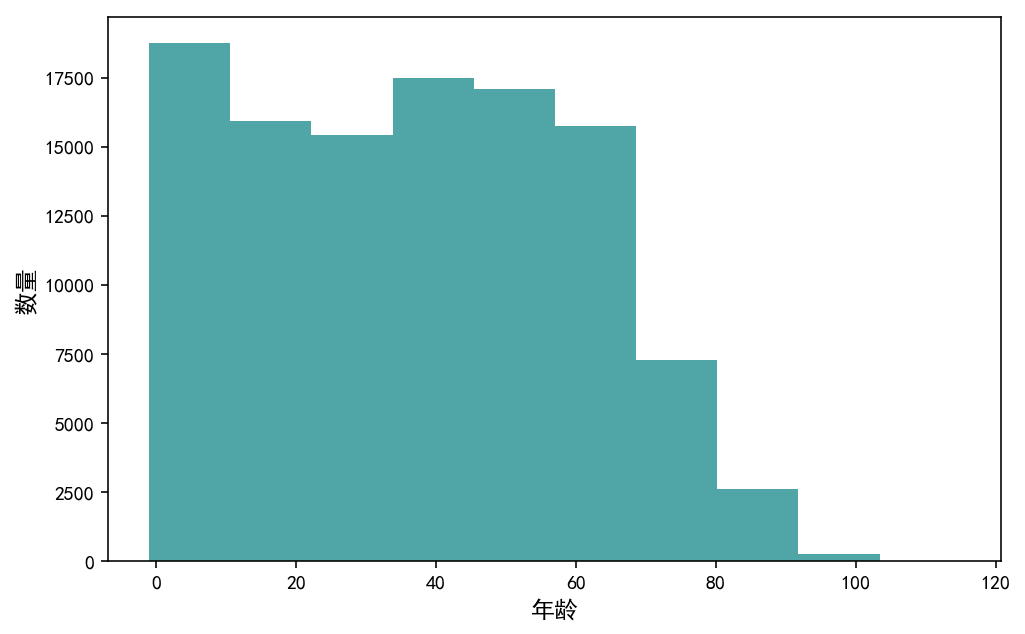

In [13]:
plt.figure(figsize=(8,5))
plt.hist(df['Age'],color='#50A5A6')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(u'年龄',fontsize=12)
plt.ylabel(u'数量',fontsize=12);

年龄的分布有两个峰，分别对应10岁以下和50岁左右的居民。而高龄老人预约就诊的情况较少。

**5) Neighborhood变量**

In [14]:
df['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
CENTRO                         3334
TABUAZEIRO                     3132
SANTA MARTHA                   3131
JESUS DE NAZARETH              2853
BONFIM                         2773
SANTO ANTÔNIO                  2746
SANTO ANDRÉ                    2571
CARATOÍRA                      2565
JABOUR                         2509
SÃO PEDRO                      2448
ILHA DO PRÍNCIPE               2266
NOVA PALESTINA                 2264
ANDORINHAS                     2262
DA PENHA                       2217
ROMÃO                          2215
GURIGICA                       2018
SÃO JOSÉ                       1977
BELA VISTA                     1907
MARUÍPE                        1902
FORTE SÃO JOÃO                 1889
ILHA DE SANTA MARIA            1885
SÃO CRISTÓVÃO                  1836
REDENÇÃO                    

这是医院位置信息，一共有81家医院。可以发现，不同医院的预约就诊数量差异巨大，预约量最多的医院达到了7000多次，最少的医院才1次。

**6) Scholarship变量**

In [15]:
df['Scholarship'].value_counts()/df['Scholarship'].count()

0    0.901734
1    0.098266
Name: Scholarship, dtype: float64

Scholarship字段取值只包括0和1，不包含其它取值，说明没有错误的取值。同时可以看出，领取了政府补助金的居民数量只占到了不到10%。

**7) Hipertension变量**

In [16]:
df['Hipertension'].value_counts()/df['Hipertension'].count()

0    0.802754
1    0.197246
Name: Hipertension, dtype: float64

Hipertension字段取值只包括0和1，不包含其它取值，说明没有错误的取值。同时可以看出，患有高血压的居民数量占到了将近20%。

**8) Diabetes变量**

In [17]:
df['Diabetes'].value_counts()/df['Diabetes'].count()

0    0.928135
1    0.071865
Name: Diabetes, dtype: float64

Diabetes字段取值只包括0和1，不包含其它取值，说明没有错误的取值。同时可以看出，患有糖尿病的居民数量占据7.2%左右。

**9) Alcoholism变量**

In [18]:
df['Alcoholism'].value_counts()/df['Alcoholism'].count()

0    0.9696
1    0.0304
Name: Alcoholism, dtype: float64

Alcoholism字段取值只包括0和1，不包含其它取值，说明没有错误的取值。同时可以看出，酗酒的居民数量占据3%左右，这说明当地酗酒的人不是很多。

**10) Handcap变量**

In [19]:
df['Handcap'].value_counts()/df['Handcap'].count()

0    0.979724
1    0.018475
2    0.001656
3    0.000118
4    0.000027
Name: Handcap, dtype: float64

Handcap字段取值取值只包括0、1、2、3、4，不包含其它取值，说明没有错误的取值。同时可以看出，没有残疾的人占据了将近98%，有残疾的人大多也只有1处残疾，2处以上残疾的居民数量不到0.2%。

**11) SMS_received变量**

In [20]:
df['SMS_received'].value_counts()/df['SMS_received'].count()

0    0.678974
1    0.321026
Name: SMS_received, dtype: float64

SMS_received字段取值取值只包括0和1，不包含其它取值，说明没有错误的取值。同时可以看出，超过三分之二的就诊是没有收到通知短信提醒的。通过查阅维基百科资料https://en.wikipedia.org/wiki/Vit%C3%B3ria,_Esp%C3%ADrito_Santo#Economy 发现，维多利亚市是生活质量较高的省会城市，因此不可能出现三分之二的居民没有手机的情况。因此，没有收到通知短信，很有可能是医院或相关机构没有发出通知导致的。

**12) No-show变量**

In [21]:
df['No-show'].value_counts()/df['No-show'].count()

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

No_Show字段取值只包括Yes和NO，不包含其它取值，说明没有错误的取值。同时可以看出，缺席率略微超出20%。

#### 3. 数据冗余情况

In [22]:
df.duplicated(subset='AppointmentID').sum()

0

这说明没有数据冗余

#### 4. 数据之间的相关性

In [23]:
df.corr()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
PatientId,1.000000,0.004039,-0.004139,-0.002880,-0.006441,0.001605,0.011011,-0.007916,-0.009749
AppointmentID,0.004039,1.000000,-0.019126,0.022615,0.012752,0.022628,0.032944,0.014106,-0.256618
Age,-0.004139,-0.019126,1.000000,-0.092457,0.504586,0.292391,0.095811,0.078033,0.012643
Scholarship,-0.002880,0.022615,-0.092457,1.000000,-0.019729,-0.024894,0.035022,-0.008586,0.001194
Hipertension,-0.006441,0.012752,0.504586,-0.019729,1.000000,0.433086,0.087971,0.080083,-0.006267
Diabetes,0.001605,0.022628,0.292391,-0.024894,0.433086,1.000000,0.018474,0.057530,-0.014550
Alcoholism,0.011011,0.032944,0.095811,0.035022,0.087971,0.018474,1.000000,0.004648,-0.026147
Handcap,-0.007916,0.014106,0.078033,-0.008586,0.080083,0.057530,0.004648,1.000000,-0.024161
SMS_received,-0.009749,-0.256618,0.012643,0.001194,-0.006267,-0.014550,-0.026147,-0.024161,1.000000


可见，年龄与糖尿病、高血压之间存在中等强度的正相关关系，高血压和糖尿病之间存在中等强度的正相关关系，其它变量之间不存在明显的相关关系



### 数据清理

#### 1.错误数据清理

1) 删除时间异常的记录

In [24]:
df.drop(baddf.index,axis=0,inplace=True)

In [25]:
df[df['AppointmentDay'].dt.date<df['ScheduledDay'].dt.date]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


可见，已经成功删除了时间异常的记录。

2) 删除年龄异常的记录。

In [26]:
df.drop(df[df['Age']<0].index,axis=0,inplace=True)

In [27]:
df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


可见，已经成功删除了年龄异常的记录

#### 2.数据转换

No-show变量，改名为show。同时该字段的值映射为：1——出席，0——缺席。

In [28]:
df.rename(columns={'No-show':'Show'},inplace=True)

In [29]:
df['Show']=df['Show'].map({'No':1,'Yes':0})

In [30]:
df['Show'].mean()

0.7981017182254956

可见，该变量的均值与转换前'No-show'变量中取值No的比例一致。这说明，该变量已经成功完成预期的转化。

#### 3. 转换列名

将列名中不同的单词分开，并用下划线连接

In [31]:
df.rename(columns={'PatientId':'Patient_Id','AppointmentID':'Appointment_ID','ScheduledDay':'Scheduled_Day','AppointmentDay':'Appointment_Day'},inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 14 columns):
Patient_Id         110521 non-null float64
Appointment_ID     110521 non-null int64
Gender             110521 non-null object
Scheduled_Day      110521 non-null datetime64[ns, UTC]
Appointment_Day    110521 non-null datetime64[ns, UTC]
Age                110521 non-null int64
Neighbourhood      110521 non-null object
Scholarship        110521 non-null int64
Hipertension       110521 non-null int64
Diabetes           110521 non-null int64
Alcoholism         110521 non-null int64
Handcap            110521 non-null int64
SMS_received       110521 non-null int64
Show               110521 non-null int64
dtypes: datetime64[ns, UTC](2), float64(1), int64(9), object(2)
memory usage: 12.6+ MB


转换列名完成

#### 4.新增变量

1) 新增一列，记录居民预约后需要等待的天数，取名为“Awaiting_day”

In [33]:
df['Awaiting_day']=df['Appointment_Day'].dt.date-df['Scheduled_Day'].dt.date

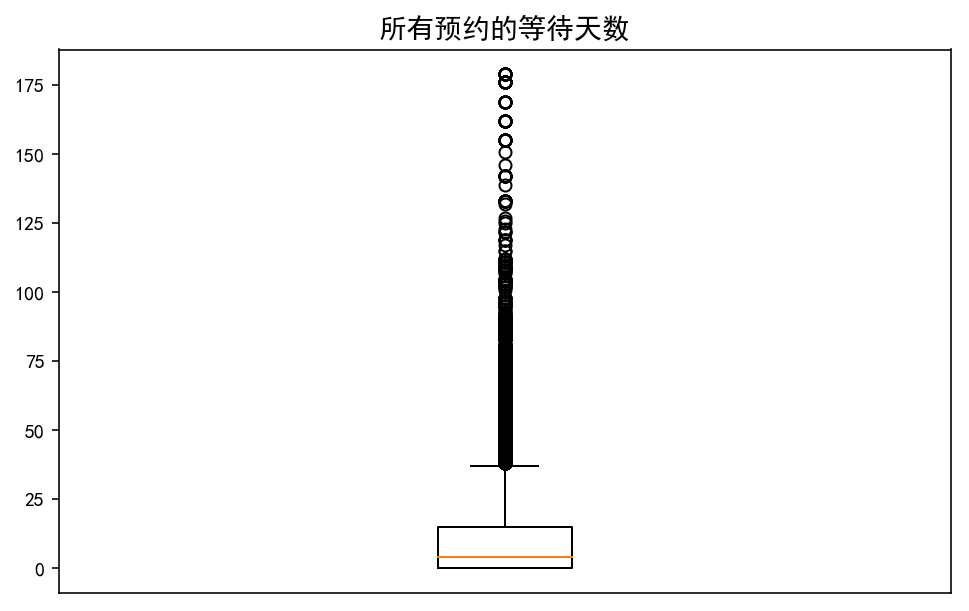

In [34]:
plt.figure(figsize=(8,5))
plt.boxplot(df['Awaiting_day']/np.timedelta64(1,'D'))
plt.xticks([])
plt.yticks(fontsize=10)
plt.title(u'所有预约的等待天数',fontsize=14);

可见，大部分居民的等待时间在1个月以内，但也有一些居民等了很长一段时间，最长接近6个月。

2) 新增一列，记录本次预约是该居民的第几次预约,取名为“Appointment_rank”

In [35]:
#一条预约信息对应于该用户的第几次预约
def app_rank(df,col='Scheduled_Day'):
    df['Appointment_rank']=df[col].rank(method='first').astype('int')
    return df.sort_values(by='Scheduled_Day')

In [36]:
df=df.groupby('Patient_Id').apply(app_rank)
df.index=df.index.droplevel()

In [37]:
df['Appointment_rank'].describe()

count    110521.000000
mean          2.270220
std           3.913467
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          88.000000
Name: Appointment_rank, dtype: float64

可见，大多数的预约都是居民的第一次预约，预约最多的居民预约了88次。

3) 新增两列，分别记录居民的过往出席次数和过往缺席次数，取名分别为“Show_record”和“Absent_record”

In [38]:
#居民进行本次预约前已出席和缺席的次数
def get_record(df):
    df=df.sort_values(by='Appointment_rank')
    df['Show_record']=df['Show'].cumsum()-df['Show']
    df['Absent_record']=df['Appointment_rank']-1-df['Show_record']
    return df

In [39]:
df=df.groupby('Patient_Id').apply(get_record)
df.index=df.index.droplevel()

4) 新增一列，记录居民的总预约次数，取名为“Appointment_count”

In [40]:
ap_count=df.groupby('Patient_Id')['Appointment_rank'].max().reset_index().rename(columns={'Appointment_rank':'Appointment_count'})
df=df.merge(ap_count,on='Patient_Id',how='left')

5) 新增两列，分别记录居民的总出席次数和总缺席次数，取名分别为“Show_count”和“Absent_count”

In [50]:
sh_ab_count=df.groupby(['Patient_Id','Show']).size().unstack(level='Show').rename(columns={0:'Absent_count',1:'Show_count'}).fillna(0).astype('int')
df=df.merge(sh_ab_count,on='Patient_Id',how='left')

<a id='eda'></a>
## 数据分析

### 1. 时间因素

#### 1) 出席率随时间的变化趋势

In [56]:
df.groupby(df['Scheduled_Day'].dt.to_period('M'))['Appointment_ID'].count().reset_index().rename(columns={'Scheduled_Day':u'预约时间','Appointment_ID':u'预约量'})

D:\BaiduNetdiskDownload\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,预约时间,预约量
0,2015-11,1
1,2015-12,61
2,2016-01,60
3,2016-02,281
4,2016-03,3614
5,2016-04,25339
6,2016-05,67416
7,2016-06,13749


上表显示了不同月份的预约数量。可见，绝大部分预约都集中在2016年4月-6月，2015年11月的预约仅有1次。为了排除分母过小的影响，选取2015年12月以后的预约信息，来查看赴约率的变化趋势

D:\BaiduNetdiskDownload\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


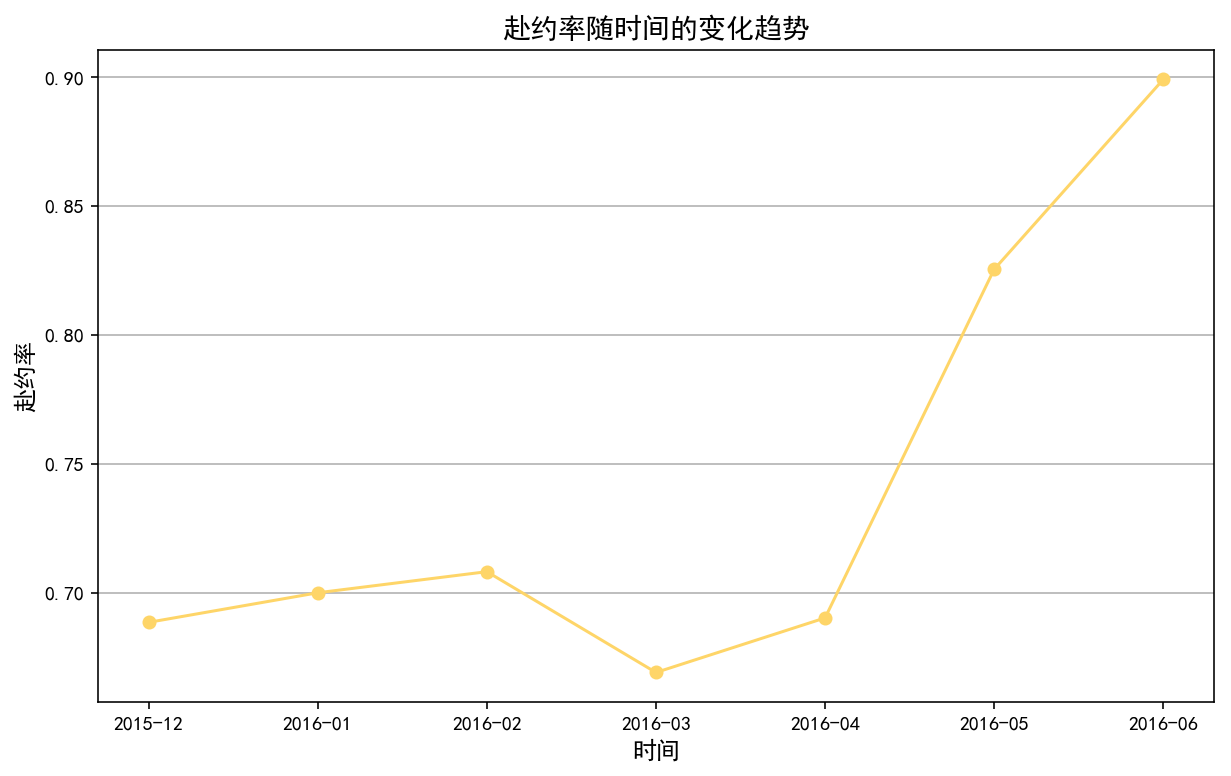

In [57]:
import datetime
trend_rate=df[df['Scheduled_Day'].dt.month!=11].groupby(df['Scheduled_Day'].dt.to_period('M'))['Show'].mean()
plt.figure(figsize=(10,6))
plt.plot(range(trend_rate.size),trend_rate.values,'o-',color='#FED568');
plt.xticks(range(trend_rate.size),list(trend_rate.index),fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y')
plt.xlabel(u'时间',fontsize=12)
plt.ylabel(u'赴约率',fontsize=12)
plt.title(u'赴约率随时间的变化趋势',fontsize=14);

可见，2016年4月及以前预约的赴约率是较低的，5月和6月预约的赴约率较高。而实际就诊的日期最早也是从2016年4月29日开始，因此，在2016年4月以前预约的居民很有可能是因为等待时间过长而没有按时赴约。

#### 2) 等待时间与出席率的相关性

将等待时间分为以下几个时间段：0天(即当天就诊)、1天、2天、3天、4天、5天、6-7天、8-10天、11-15天、16-30天、30天-60天、60天以上

In [58]:
df['Awaiting_day_divide']=pd.cut(df['Awaiting_day'].astype('timedelta64[D]'),[-1,0,1,2,3,4,5,7,10,15,30,60,200],labels=[u'当天就诊','1','2','3','4','5','6-7','8-10','11-15','16-30','30-60',u'60以上'])

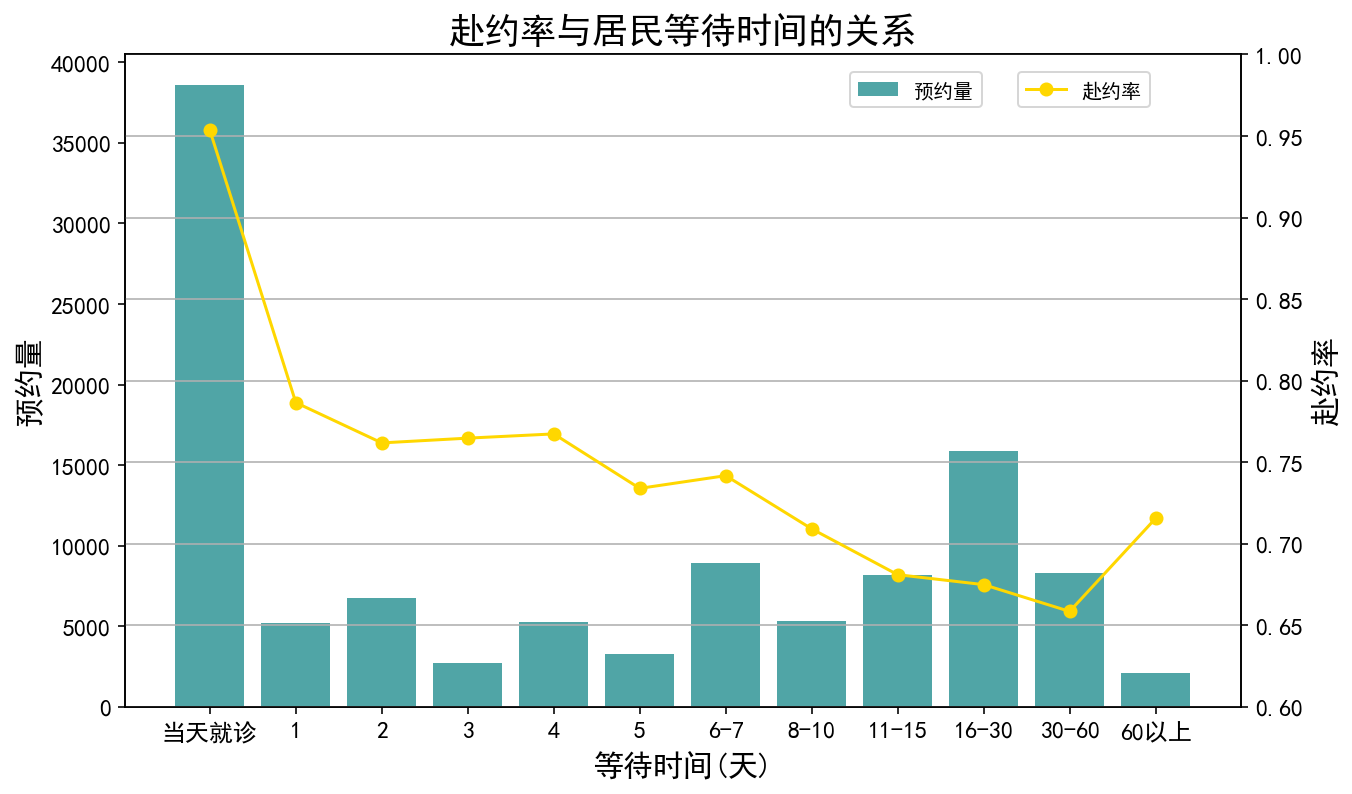

In [167]:
wait_count=df.groupby(['Awaiting_day_divide'])['Show'].count().sort_index()
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(111)
ax1.bar(range(1,wait_count.size+1),wait_count.values.tolist(),color='#50A5A6');
plt.legend(['预约量'],loc=(0.65,0.92))
plt.xticks(range(1,wait_count.size+1),wait_count.index.tolist(),fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'等待时间(天)',fontsize=15);
plt.ylabel(u'预约量',fontsize=15);
ax2=ax1.twinx()
wait_mean=df.groupby(['Awaiting_day_divide'])['Show'].mean()
ax2.plot(range(1,wait_mean.size+1),wait_mean.values.tolist(),'o-',color='#FFD700');
plt.legend(['赴约率'],loc=(0.8,0.92))
plt.yticks(np.linspace(0.6,1,9),fontsize=12)
plt.grid(axis='y')
plt.ylim([0.6,1])
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与居民等待时间的关系',fontsize=18);

数据显示，当天就诊的赴约率远远高于需要等待1天以上的赴约率。当等待时间超过1个星期时，赴约率会比较低。有一点比较反常的是，当等待时间超过2个月时，赴约率反而会相对较高，这可能是由于提前几个月预约的居民往往相对更重视此次就诊。但其赴约率仍然低于等待时间不超过1星期的情况。

#### 3) 在哪些时间点上做出的预约更有可能出现爽约的现象

**a. 一个星期中哪几天的预约更有可能出现爽约的情况**

In [60]:
S_weekday_rate=df.groupby(df['Scheduled_Day'].dt.dayofweek)['Show'].agg(['count','mean'])
S_weekday_rate.to_csv('S_weekday_rate.csv')

In [133]:
%%html
<img src="预约星期X-赴约率.jpg" width=80%>

数据显示，预约主要集中在周一到周五，周末的预约可以忽略不计。赴约率与一星期中哪一天做出的预约没有明显的关联。(注：由于星期六的预约数量只有24次，因此星期六的赴约率受个体随机因素影响较大，不具备参考性。)

**b. 一天中哪几个时间段的预约更有可能出现爽约的情况**

In [62]:
S_hour_rate=df.groupby(df['Scheduled_Day'].dt.hour)['Show'].agg(['count','mean'])
S_hour_rate.to_csv('S_hour_rate.csv')

In [134]:
%%html
<img src="x时预约-赴约率.jpg" width=80%>

数据显示，一天的预约从清晨6点开始，到晚上10点结束。清晨时的预约会出现较高的赴约率，20点以后的赴约率明显低于其它时间的赴约率。考虑到20点以后的预约量较少且赴约率低，可以尝试将预约提前到20点结束，这样做一方面可以减轻工作人员的负担，另一方面也有利于提高赴约率。

#### 4)在哪些时间点上就诊更可能出现爽约现象？

**a. 在一个星期的哪一天就诊更可能缺勤？**

In [64]:
A_weekday_show=df.groupby(df['Appointment_Day'].dt.dayofweek)['Show'].agg(['count','mean'])
A_weekday_show.to_csv('a_weekday_show.csv')

In [135]:
%%html
<img src="就诊星期x-赴约率.jpg" width=80%>

可见，就诊时间几乎都安排在周一至周五，换句话说，几乎所有患者都需要通过向公司请假来完成就诊，这或许是赴约率不高的原因之一。<br>
另外，排除分母过小的因素后，从周一到周六，赴约率没有明显的差异。

#### 5) 小结

- 尽量将就诊时间安排在预约的当天，因为当天就诊的赴约率远高于需要等待1天以上的情况。<br><br>
- 若无法将就诊时间安排在当天，尽量让等待时间低于7天。若无法满足等待时间低于7天，就最好让等待时间超过2个月。因为等待时间介于1周和2个月之间的赴约率是最低的。<br><br>
- 可以尝试将一天中的预约时间提前到20点结束，因为20-22点预约的赴约率低于其它时间段，并且这个时间段的预约量很小。提前结束可以减轻工作人员的负担，同时对居民的预约需求影响极小，还有利于提高赴约率。<br><br>
- 如果尝试将就诊时间开放至周末，可能会改善出勤状况。

## 2.居民特征

#### 1）个人基本情况

**a. 性别与赴约率的关系**

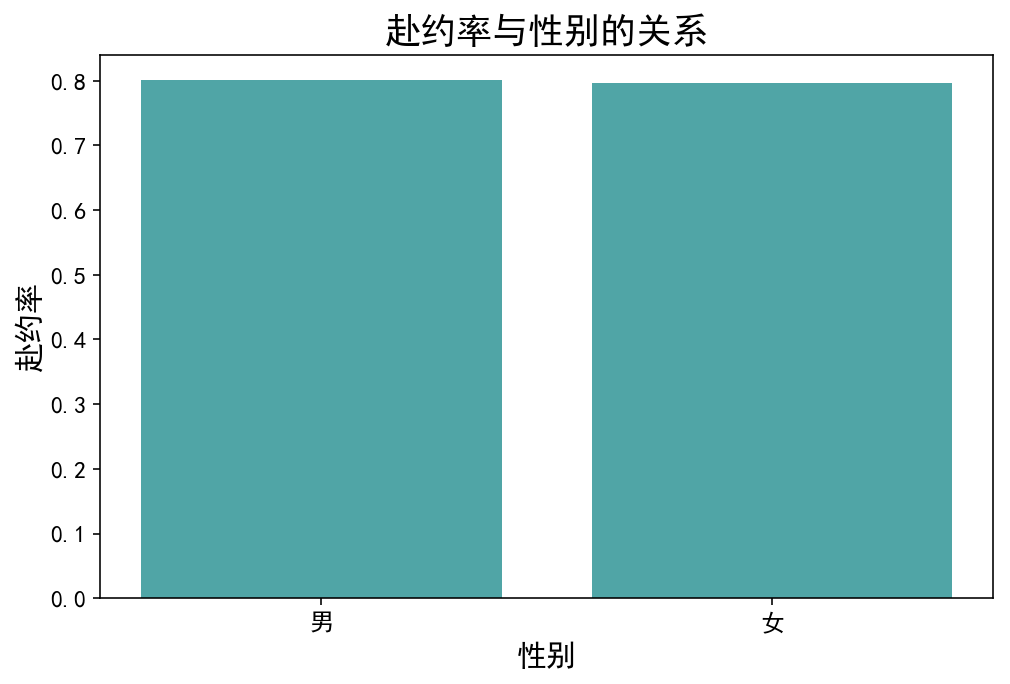

In [168]:
Gender_attend=df.groupby(['Gender'])['Show'].mean()
plt.figure(figsize=(8,5))
plt.bar(range(1,3),[Gender_attend['M'],Gender_attend['F']],tick_label=[u'男',u'女'],color='#50A5A6');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'性别',fontsize=15);
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与性别的关系',fontsize=18);

In [67]:
Gender_count=df.groupby('Gender').size().reset_index().rename(columns={'Gender':u'性别',0:u'数量'})
Gender_count[u'性别']=Gender_count[u'性别'].map({'M':u'男','F':u'女'})
Gender_count

,性别,数量
0,女,71836
1,男,38685


可见，赴约率与性别没有明显的关联。

**b. 年龄和赴约率的关系**

In [68]:
#将年龄按等预约数量分为12组
age_show=df.groupby(pd.qcut(df['Age'],12,precision=0))['Show'].agg([('attend_rate','mean'),'count']).reset_index()

In [69]:
age_show['Age']=age_show['Age'].astype('str').apply(lambda x:str(int(float(x[x.index('(')+1:x.index(',')]))+1)+'-'+str(int(float(x[x.index(',')+1:x.index(']')]))))
age_show.to_csv('age_show.csv')

In [136]:
%%html
<img src="年龄-赴约率.jpg" width=80%>

可见，出席率随年龄的增长而呈现先下降后上升的趋势，其中，11-24岁的居民出席率最低。年龄小的居民出席率高，可能是由于父母对病情的关注；年龄较大的居民出席率高，可能是因为中老年人对待事物相对慎重，对自己的健康也比较关心，会把预约就诊的事放在心上；而青少年可能做决定比较轻率，于是造成了爽约较多的情况。

**c. 政府贫困补助金领取情况和赴约率的关系**

In [71]:
scho_wait_SMS_rate=df.groupby(['Scholarship','Awaiting_day_divide','SMS_received'])['Show'].agg(['count','mean']).unstack(level=['Scholarship','SMS_received'])
scho_wait_SMS_rate.to_csv('scholarship_wait_SMS_rate.csv')

In [137]:
%%html
<img src="等待天数-补助-赴约率.jpg" width=80%>

数据显示，当等待时间不超过3天时，领取贫困补助金的居民与没有贫困补助金的居民在赴约率上差异不大；当等待时间超过3天时，领取贫困补助金的居民与没有贫困补助金的居民在出席率上的差异大大增加，差异超过了10个百分点。这表明，等待时间的延长对于领取贫困补助金的居民影响更大。<br><br>
那么，为什么在等待时间较长时领取贫困补助的居民出勤情况会很糟糕呢？下图给出了一定的解释。

In [138]:
%%html
<img src="补助-短信-赴约率.jpg" width=80%>

接收通知短信对于领取贫困补助居民的出勤提升效果大于不领取贫困补助的居民，这表明，领取贫困补助的居民更有可能忘记自己原先的预约。<br><br>
除开通知短信的因素，在等待时间较长时，领取补助金的居民在出勤上的表现仍然较大幅度地差于没领取补助金的居民，这说明领取贫困补助金的居民更有可能改变自己原先就诊的决定。
<br><br>之所以这些居民会改变自己的就诊决定，可能是因为：(1)他们相对于较富有的居民来说不那么相信医院的治疗效果，他们可能更容易去相信一些民间流传的偏方或者宗教治病的观念；(2)他们还可能在预约后又感觉自己病没那么重了，于是觉得没有必要治疗。这些情况发生的概率随着等待时间的延长而加大。
<br><br>
基于以上分析，建议：
1. 等待时间较长时，及时发送通知短信，以防居民忘记预约
2. 尽量让领取贫困补助的居民尽快就诊
3. 在居民等待的过程中，加大对于医疗科学有效性的宣传，教育居民不要随意相信某些偏方
4. 针对病情理解的误区进行科普，防止自以为病好了就不再就诊的情况发生
5. 将领取贫困补助金的资格与就诊出席率捆绑，减少领取补助居民浪费资源的情况发生

#### 2）个人健康情况

**a. 赴约率与患高血压的关系**

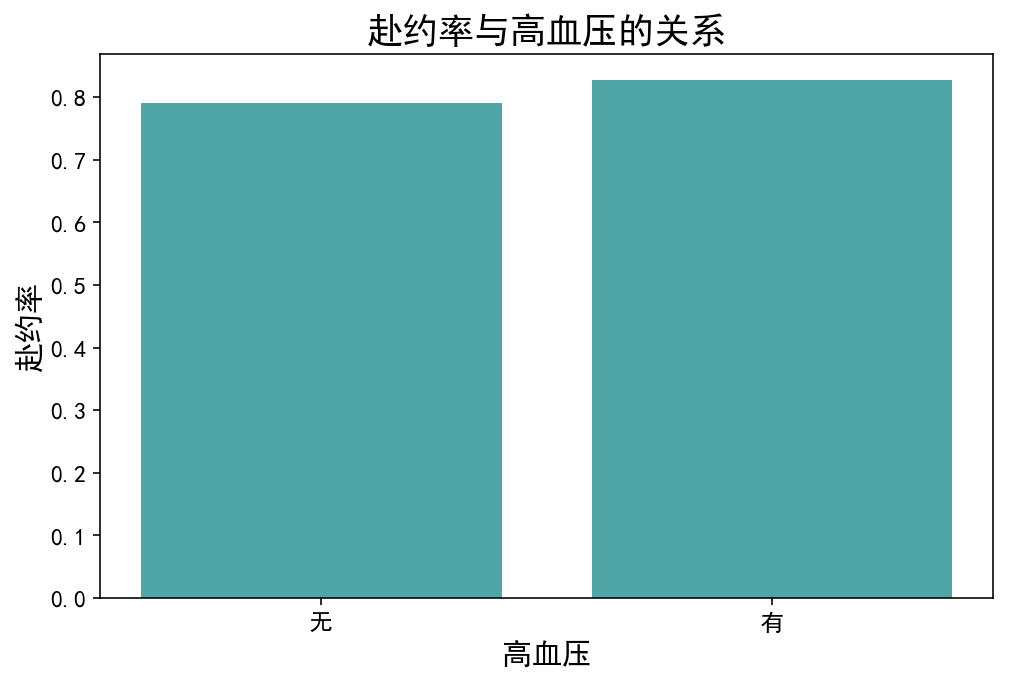

In [169]:
Hip_attend=df.groupby(['Hipertension'])['Show'].mean()
plt.figure(figsize=(8,5))
plt.bar(range(1,3),[Hip_attend[0],Hip_attend[1]],tick_label=[u'无',u'有'],color='#50A5A6');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'高血压',fontsize=15);
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与高血压的关系',fontsize=18);

In [75]:
Hip_count=df.groupby(['Hipertension']).size().reset_index().rename(columns={'Hipertension':u'高血压',0:u'数量'})
Hip_count[u'高血压']=Hip_count[u'高血压'].map({0:u'无',1:u'有'})
Hip_count

,高血压,数量
0,无,88720
1,有,21801


可见，高血压患者的赴约率略高于非高血压患者

**b. 赴约率与患糖尿病的关系**

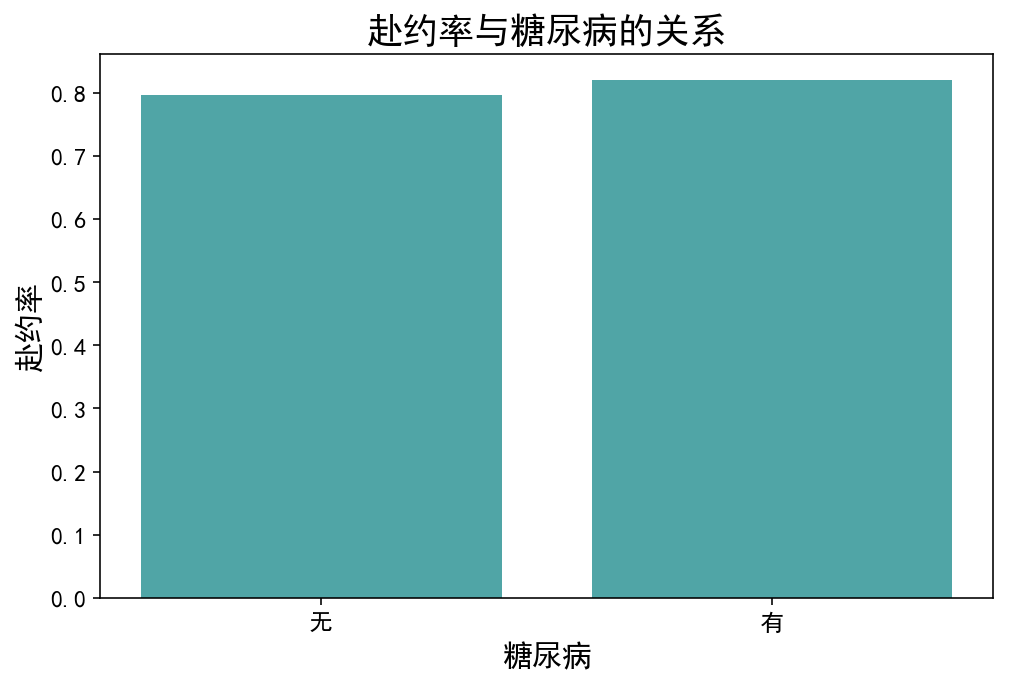

In [170]:
Dia_attend=df.groupby(['Diabetes'])['Show'].mean()
plt.figure(figsize=(8,5))
plt.bar(range(1,3),[Dia_attend[0],Dia_attend[1]],tick_label=[u'无',u'有'],color='#50A5A6');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'糖尿病',fontsize=15);
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与糖尿病的关系',fontsize=18);

In [77]:
Dia_count=df.groupby(['Diabetes']).size().reset_index().rename(columns={'Diabetes':u'糖尿病',0:u'数量'})
Dia_count[u'糖尿病']=Dia_count[u'糖尿病'].map({0:u'无',1:u'有'})
Dia_count

,糖尿病,数量
0,无,102578
1,有,7943


可见，糖尿病患者的赴约率比非糖尿病患者略微高出一点

**c. 赴约率与酗酒的关系**

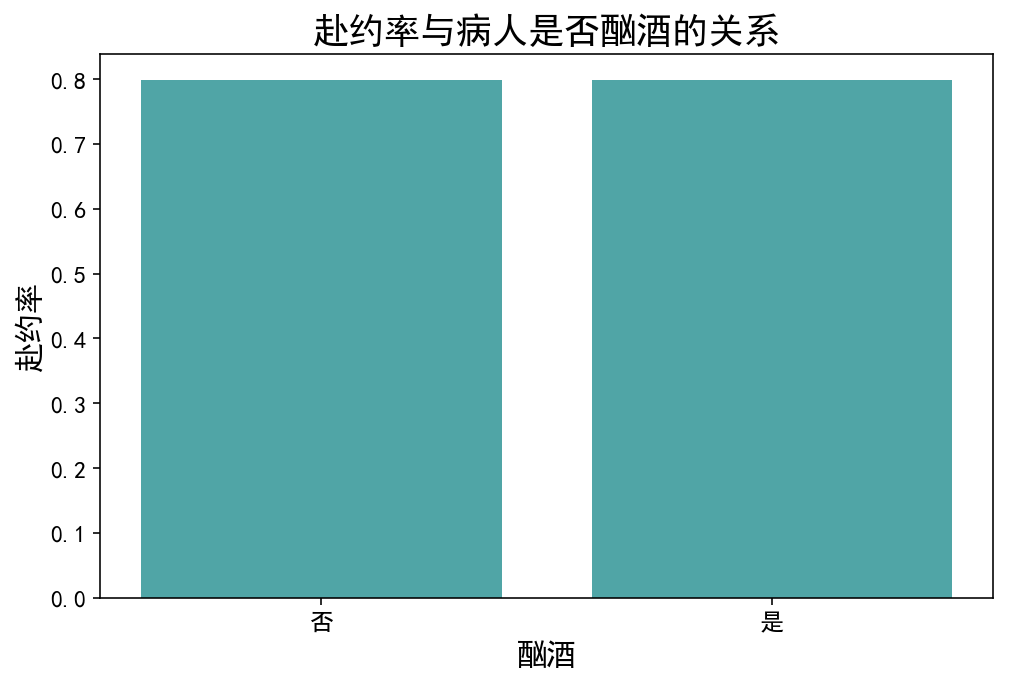

In [171]:
Alc_attend=df.groupby(['Alcoholism'])['Show'].mean()
plt.figure(figsize=(8,5))
plt.bar(range(1,3),[Alc_attend[0],Alc_attend[1]],tick_label=[u'否',u'是'],color='#50A5A6');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'酗酒',fontsize=15);
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与病人是否酗酒的关系',fontsize=18);

In [79]:
Alc_count=df.groupby(['Alcoholism']).size().reset_index().rename(columns={'Alcoholism':u'酗酒',0:u'数量'})
Alc_count[u'酗酒']=Alc_count[u'酗酒'].map({0:u'否',1:u'是'})
Alc_count

,酗酒,数量
0,否,107161
1,是,3360


可见，赴约率与是否酗酒没有关系

**d. 赴约率与残疾程度的关系**

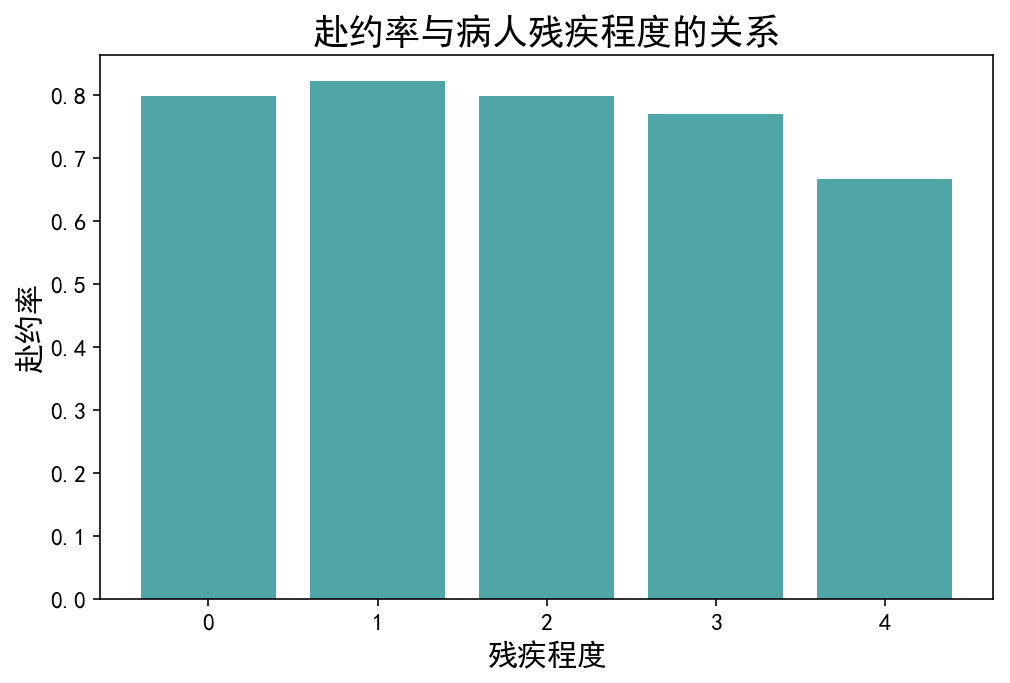

In [172]:
Han_attend=df.groupby(['Handcap'])['Show'].mean()
plt.figure(figsize=(8,5))
plt.bar(Han_attend.index,Han_attend.values,color='#50A5A6');
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(u'残疾程度',fontsize=15);
plt.ylabel(u'赴约率',fontsize=15);
plt.title(u'赴约率与病人残疾程度的关系',fontsize=18);

In [81]:
df.groupby(['Handcap']).size().reset_index().rename(columns={'Handcap':u'残疾程度',0:u'数量'})

,残疾程度,数量
0,0,108282
1,1,2040
2,2,183
3,3,13
4,4,3


从整体上看，居民的残疾程度对赴约率的影响极小。（注：由于残疾程度在3以上的病人数量过小，其赴约率受个体因素影响较大，因此这些病人的整体赴约率参考性不大。）

#### 3）人群分布

**a. 预约是否存在80/20定律，即是否大部分的预约集中于少部分居民身上？**

In [82]:
App_num=df.groupby('Patient_Id')['Appointment_ID'].count()

In [83]:
count_num=App_num.value_counts().sort_index().reset_index()
count_num.rename(columns={'index':'Appointment_count','Appointment_ID':'patient_num'},inplace=True)


In [84]:
count_num['Appointment_sum']=count_num['Appointment_count']*count_num['patient_num']

In [85]:
count_dis_num=count_num.groupby(pd.cut(count_num['Appointment_count'],[0,1,2,3,5,10,100],labels=['1次预约','2次预约','3次预约','4-5次预约','6-10次预约','10次以上预约']))['patient_num','Appointment_sum'].sum()
#统计结果导出到excel来可视化
count_dis_num.to_csv('count_dis_num.csv',encoding='utf_8_sig')


统计结果输出到excel后，进行可视化的结果如下

In [145]:
%%html
<img src="预约分布.jpg" width=70%>

可见，大部分的居民只进行了1次预约，但这些居民的预约总量仅占到了1/3左右；而进行6次以上预约的居民只占8%左右，而这些居民的预约总次数占到了1/4以上。因此，预约存在一定程度的80/20现象。

**b. 缺席是否存在80/20定律，即是否大部分的缺席集中于少部分居民身上？**

In [87]:
df.loc[df['Show']==0,'Patient_Id'].nunique()/df['Patient_Id'].nunique()

0.28349224694211694

缺席的人数占据了28%

In [88]:
absent=df[df['Show']==0]
ab_count=absent.groupby('Patient_Id')['Appointment_ID'].count().value_counts().sort_index().reset_index()

In [89]:
ab_count.rename(columns={'index':'absent_count','Appointment_ID':'patient_count'},inplace=True)

In [90]:
ab_count['absent_sum']=ab_count['absent_count']*ab_count['patient_count']


In [91]:
ab_dis_num=ab_count.groupby(pd.cut(ab_count['absent_count'],[0,1,2,3,100],labels=['1次缺席','2次缺席','3次缺席','4次以上缺席'])).agg({'patient_count':'sum','absent_sum':'sum'}).reset_index()

#统计结果导出到excel来可视化
ab_dis_num.to_csv('ab_dis_num.csv',encoding='utf_8_sig')

In [92]:
ab_dis_num.columns=['缺席次数','病人数量','缺席总量']
ab_dis_num['缺席次数']=ab_dis_num['缺席次数'].str.replace('缺席','')
ab_dis_num

,缺席次数,病人数量,缺席总量
0,1次,14438,14438
1,2次,2415,4830
2,3次,516,1548
3,4次以上,292,1498


In [144]:
%%html
<img src="缺席的分布.jpg" width=70%>

可见，大多数居民都只缺席了一次，总体来看，居民的缺席频次不高。缺席的总量没有出现二八现象，而是相对均匀的分布在每一个缺席的居民中。因此，不存在“几颗老鼠屎，坏了一锅粥”的现象。

**c. 是否存在多次预约但从不出席的居民？**

In [94]:
#从不出席的居民的预约次数分布情况
never_show=df[df['Show_count']==0]
never_count=never_show.groupby('Patient_Id')['Appointment_count'].max()
never_count.sort_values(ascending=False).reset_index().rename(columns={'Patient_Id':u'居民Id','Appointment_count':u'预约次数'}).head(20)

,居民Id,预约次数
0,1.421987e+12,18
1,5.635135e+14,16
2,5.811973e+14,14
3,6.575144e+13,13
4,9.338860e+13,10
5,4.683678e+13,9
6,2.162982e+11,8
7,2.851680e+10,7
8,3.484979e+13,7
9,9.717348e+10,6


上表是多次预约且零出席的居民中，预约次数最多的20名

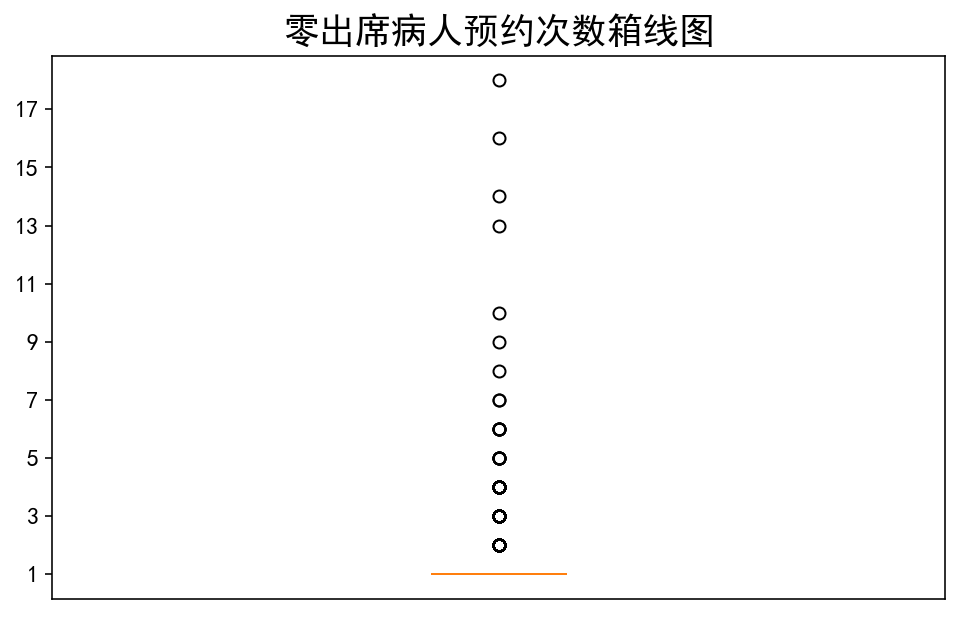

In [173]:
plt.figure(figsize=(8,5))
plt.boxplot(never_count)
plt.xticks([])
plt.yticks(range(1,19,2),fontsize=12)
plt.title(u'零出席病人预约次数箱线图',fontsize=18);

可见，几乎所有没有出席记录的居民都只预约了一次。预约了10次以上，但从未出席的居民一共只有5人。因此，有多次预约但从不出席的情况，但只是发生在极个别人的身上。

把这些预约了10次以上但一直缺席的居民的预约信息调取出来查看后，没有发现明显的共同特征。这表明，这些多次预约从不出席的居民很可能是出于个人原因做出这样的行为。

**d.缺席的情况更多发生于第一次预约的新用户还是已多次预约的老用户?**

In [96]:
app_rank=df.groupby('Appointment_rank').agg({'Appointment_ID':'count','Show':'mean'}).reset_index().rename(columns={'Appointment_ID':'count','Show':'rate'})
app_rank.to_csv('app_rank.csv')

In [174]:
%%html
<img src="第X次预约.jpg" width=70%>

从第1次预约到第15次预约，赴约率的变化总体不大，约99%的预约都属于这种情况。第15次以后的预约明显拥有更高的赴约率，且随着预约次数的增加，赴约率整体呈现上升趋势。

#### 4）过往出席记录与赴约率的联系

用逻辑回归来看待赴约率与已出席次数、已缺席次数之间的关系

In [98]:
df['intercept']=1
logit_mod=sm.Logit(df['Show'],df[['intercept','Show_record','Absent_record']])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.495647
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Show   No. Observations:               110521
Model:                          Logit   Df Residuals:                   110518
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Apr 2019   Pseudo R-squ.:                 0.01466
Time:                        22:06:28   Log-Likelihood:                -54779.
converged:                       True   LL-Null:                       -55595.
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         1.3673      0.009    160.619      0.000       1.351       1.384
Show_record       0.1267      0.005     23.044      0.000       0.116       0.138
Absent_record    -0.3653      0.011    -32.864      0.000      -0.387      -0.344
=================================================================================
"""

In [99]:
np.exp(0.1268),np.exp(-0.3653)

(1.1351899570847568, 0.6939884231184411)

逻辑回归的结果显示，赴约率与过去的出席、缺席次数呈统计性显著的相关关系。且在其它条件不变的情况下，过往记录中出席次数每增加1次，出席的概率增加13%;过往记录中缺席次数每增加1次，出席的概率减少31%

#### 5）小结

* 11-24岁的青少年较其它年龄段有更严重的缺席情况，这可能与该年龄段的青少年做决定更加轻率有关。


* 等待时间超过3天时，领取贫困补助居民的赴约率明显低于无补助的居民。这一方面是因为领取贫困补助的居民更容易忘记原先的预约，另一方面也可能是因为领取贫困补助的居民更容易主观上改变要就诊的决定。一些领取贫困补助的居民之所以会故意放弃就诊，可能是因为：(a)他们更容易去相信一些民间流传的偏方或者宗教治病的观念；(b)他们在预约后又感觉自己病没那么重了，于是觉得没有必要治疗。基于此，建议：
  - 等待时间较长时，及时发送通知短信，以防居民忘记预约
  - 尽量让领取贫困补助的居民尽快就诊
  - 在居民等待的过程中，加大对于医疗科学有效性的宣传，教育居民不要随意相信某些偏方
  - 针对病情理解的误区进行科普，防止自以为病好了就不再就诊的情况发生
  - 将领取贫困补助金的资格与就诊出席率捆绑，减少领取补助居民浪费资源的情况发生
  
  
* 大部分的预约由少部分预约频次较高的居民做出。


* 存在缺席现象的居民中，超过90%的居民仅缺席1-2次，有极个别大量预约但从不出席的居民，但这些居民对于整体赴约率的影响非常微小。这些大量预约但从不出席的居民没有明显的共同特征，推测是个人原因爽约，建议针对这部分居民建立黑名单制度。


* 缺席的情况更多发生于前15次预约，而这些预约的总量占据了所有预约总量的99%左右。可以尝试针对已多次预约且记录良好的居民开放绿色通道。


* 在排除个体因素后，赴约率与过去的出席、缺席次数有明显的相关关系。且在其它条件不变的情况下，过往记录中出席次数每增加1次，下次出席的概率增加13%;过往记录中缺席次数每增加1次，下次出席的概率减少31%。

## 3.医院因素

#### 1）医院位置

In [100]:
nei_attend=df.groupby('Neighbourhood').agg({'Appointment_ID':'count','Show':'mean'}).reset_index().rename(columns={'Appointment_ID':'count','Show':'rate'})

In [101]:
nei_attend[nei_attend['count']>=50].to_csv('nei_attend.csv',encoding='utf-8')

In [158]:
%%html
<img src="街区赴约率.jpg" width=80%>

在排除低样本数量的影响后，不同医院位置的赴约率差异可以达到10个百分点以上。因此，医院位置对赴约率是有较大影响的。

通过查阅病人对于赴约率前5名和后5名医院的评价(信息来源：Google地图)，发现：赴约率靠前的医院往往具有服务质量好，医生技术水平高的特点，也有少数病人认为这些医院流程进展缓慢；而赴约率低的医院往往具有医生水平较差、无人接听电话、流程进展缓慢的特点，但也有一些病人认为这些医院的服务质量好。

下面的4个评价是典型的对于赴约率高医院的评价

In [157]:
%%html
<img src="高赴约率医院评价.jpg" width=40%>

下面的2个评价是典型的对于赴约率低医院的评价

In [155]:
%%html
<img src="低赴约率医院评价.jpg" width=40%>

因此，加强对电话接听人员的监管、简化流程、提高医生的专业水平可以帮助提高赴约率。

#### 2) 短信发送

In [105]:
SMS_wait_rate=df.groupby(['SMS_received','Awaiting_day_divide'])['Show'].agg(['count','mean']).reset_index()
SMS_wait_rate.to_csv('SMS_wait_rate.csv')

In [151]:
%%html
<img src="短信-等待时间-赴约率.jpg" width=75%>

数据显示，当等待时间不超过2天时，所有病人都没有被发送通知短信；等待时间超过3天时，被发送通知短信的预约数量略微超过没有通知提醒的预约数量。在同样的等待天数下，有通知短信的赴约率会高于没有通知短信的赴约率。因此，建议对所有等待天数超过2天的居民发送通知短信，从而改善出席情况。

#### 3）小结

* 不同医院位置对应的赴约率差异明显


* 赴约率靠前的医院往往具有服务质量好，医生技术水平高的优点；而赴约率低的医院往往具有医生水平较差、无人接听电话、流程进展缓慢的缺点。因此，建议加强对电话接听人员的监管、简化流程、提高医生的专业水平


* 在同样的等待天数下，有通知短信的赴约率会高于没有通知短信的赴约率。建议对所有等待天数超过2天的居民发送通知短信，从而改善出席情况。

<a id='conclusions'></a>
## 结论

* 就诊时间安排优先级：<br>
  当天就诊>7天内就诊>60天后就诊>其它时间就诊
  
  
* 综合考虑赴约率、居民的需求、工作人员的负担，可以尝试将预约时间提前到20点结束，并将就诊时间开放至周末。


* 11-24岁的青少年较其它年龄段有更严重的缺席情况，这可能与该年龄段的青少年做决定更加轻率有关。


* 领取贫困补助的居民更容易忘记原先的预约，针对此，建议及时发送通知短信来提醒。此外，领取贫困补助的居民更容易主观上改变要就诊的决定，改变决定的原因可能是被民间偏方、宗教治病的观念说服或对病情的误解。基于此，建议：尽量让领取贫困补助的居民尽快就诊；加大对于医疗科学有效性的宣传，教育居民不要随意相信某些偏方；针对病情理解的误区进行科普；将领取贫困补助金的资格与就诊出席率捆绑，减少领取补助居民浪费资源的情况发生。


* 存在缺席现象的居民中，超过90%仅缺席1-2次，有极个别大量预约但从不出席的居民，但这些居民对于整体赴约率的影响非常微小。这些大量预约但从不出席的居民没有明显的共同特征，推测是个人原因爽约，建议针对这部分居民建立黑名单制度。


* 在排除个体因素后，赴约率与过去的出席、缺席次数有明显的相关关系。且在其它条件不变的情况下，过往记录中出席次数每增加1次，下次出席的概率增加13%；过往记录中缺席次数每增加1次，下次出席的概率减少31%。已经预约15次以上的居民在出勤状况上明显好于预约较少的居民，第15次以后的预约只占预约总量的1%，建议针对已多次预约且记录良好的少数居民开放绿色通道。


* 赴约率靠前的医院往往具有服务质量好，医生技术水平高的优点；而赴约率低的医院往往具有医生水平较差、无人接听电话、流程进展缓慢的缺点。因此，建议加强对电话接听人员的监管、简化流程、提高医生的专业水平


* 在同样的等待天数下，有通知短信的赴约率会明显高于没有通知短信的赴约率。建议对所有等待天数超过2天的居民发送通知短信，从而改善出席情况。